In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append(f"./../")

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import List, Dict, Tuple
import seaborn as sns
from pathlib import Path

from src.qaoa_scheduling import QAOACircuit, QAOAScheduler

In [2]:
class QAOAAnalyzer:
    def __init__(self, n_vertices: int, g6_path: str, random_seed: int = None):
        if random_seed is not None:
            np.random.seed(random_seed)
        self.n_vertices = n_vertices
        self.g6_path = g6_path

    def read_g6_graphs(self) -> List[nx.Graph]:
        """Read graphs from a g6 format file."""
        with open(self.g6_path, "rb") as f:
            graphs = list(nx.read_graph6(f))
        return graphs

    def analyze_graph(self, G: nx.Graph) -> Dict:
        """Analyze a single graph for QAOA scheduling metrics."""
        # Convert graph to QAOA circuit
        # Generate random gamma values in (0, 2π]
        gamma_gates = {
            (min(u, v), max(u, v)): np.random.uniform(low=0.0, high=2 * np.pi, size=1)[
                0
            ]
            for u, v in G.edges()
        }
        circuit = QAOACircuit(
            n_qubits=G.number_of_nodes(), gamma_gates=gamma_gates, beta_time=1.0
        )

        # Create scheduler and get results
        scheduler = QAOAScheduler(circuit)
        lp_result = scheduler.solve_lp()
        layered_result = scheduler.schedule_layered()

        seqt = lp_result.total_time_before
        layt = layered_result.total_time_after
        lpt = lp_result.total_time_after

        # Calculate improvement
        improvement_percentage = np.abs(lpt - layt) / layt

        return {"edges": G.number_of_edges(), "improvement": improvement_percentage}

    def process_all_graphs(self) -> Tuple[List[int], List[float], List[float]]:
        """Process all graphs and compute statistics."""
        # Read and analyze all graphs
        graphs = self.read_g6_graphs()
        results = [self.analyze_graph(G) for G in graphs]

        # Group by edge count
        edge_groups = defaultdict(list)
        for result in results:
            edge_groups[result["edges"]].append(result["improvement"])

        # Calculate statistics for each edge count
        edge_counts = sorted(edge_groups.keys())
        means = []
        stds = []

        for edge_count in edge_counts:
            improvements = edge_groups[edge_count]
            means.append(np.mean(improvements))
            stds.append(np.std(improvements))

        return edge_counts, means, stds

    def plot_results(self):
        """Create plot with error bars."""
        # Get data
        edge_counts, means, stds = self.process_all_graphs()

        # Create figure and set style manually
        fig, ax = plt.subplots(figsize=(10, 6))

        # Set better default style
        plt.rcParams["figure.facecolor"] = "white"
        plt.rcParams["axes.facecolor"] = "white"
        plt.rcParams["axes.grid"] = True
        plt.rcParams["grid.color"] = "#E5E5E5"

        # Plot points with error bars
        ax.errorbar(
            edge_counts,
            means,
            yerr=stds,
            fmt="o-",
            capsize=5,
            capthick=1,
            elinewidth=1,
            markersize=8,
            color="#2E86C1",
            label="Mean Improvement",
        )

        # Customize plot
        ax.set_xlabel("Number of Edges", fontsize=12)
        ax.set_ylabel("LP vs Layered Improvement (%)", fontsize=12)
        ax.set_title(
            f"QAOA Scheduling Improvement vs Edge Count\n({self.n_vertices} Vertices)",
            fontsize=14,
            pad=20,
        )

        # Add grid
        ax.grid(True, linestyle="--", alpha=0.7)

        # Customize ticks
        ax.tick_params(axis="both", which="major", labelsize=10)

        # Add error bar explanation in legend
        ax.plot([], [], "k-", label="Standard Deviation")
        ax.legend(fontsize=10)

        # Adjust layout
        plt.tight_layout()

        # Save plot
        output_dir = Path("plots")
        output_dir.mkdir(exist_ok=True)
        plt.savefig(
            output_dir / f"improvement_analysis_v{self.n_vertices}.pdf",
            bbox_inches="tight",
            dpi=300,
        )
        plt.show()

        return fig, ax

# Parameters
n_vertices = 6
g6_path = f'./data/graphs/graph{n_vertices}c.g6'

# Create analyzer and run analysis
analyzer = QAOAAnalyzer(n_vertices, g6_path)
analyzer.plot_results()

print(f"Analysis complete! Plot saved as 'improvement_analysis_v{n_vertices}.pdf'")

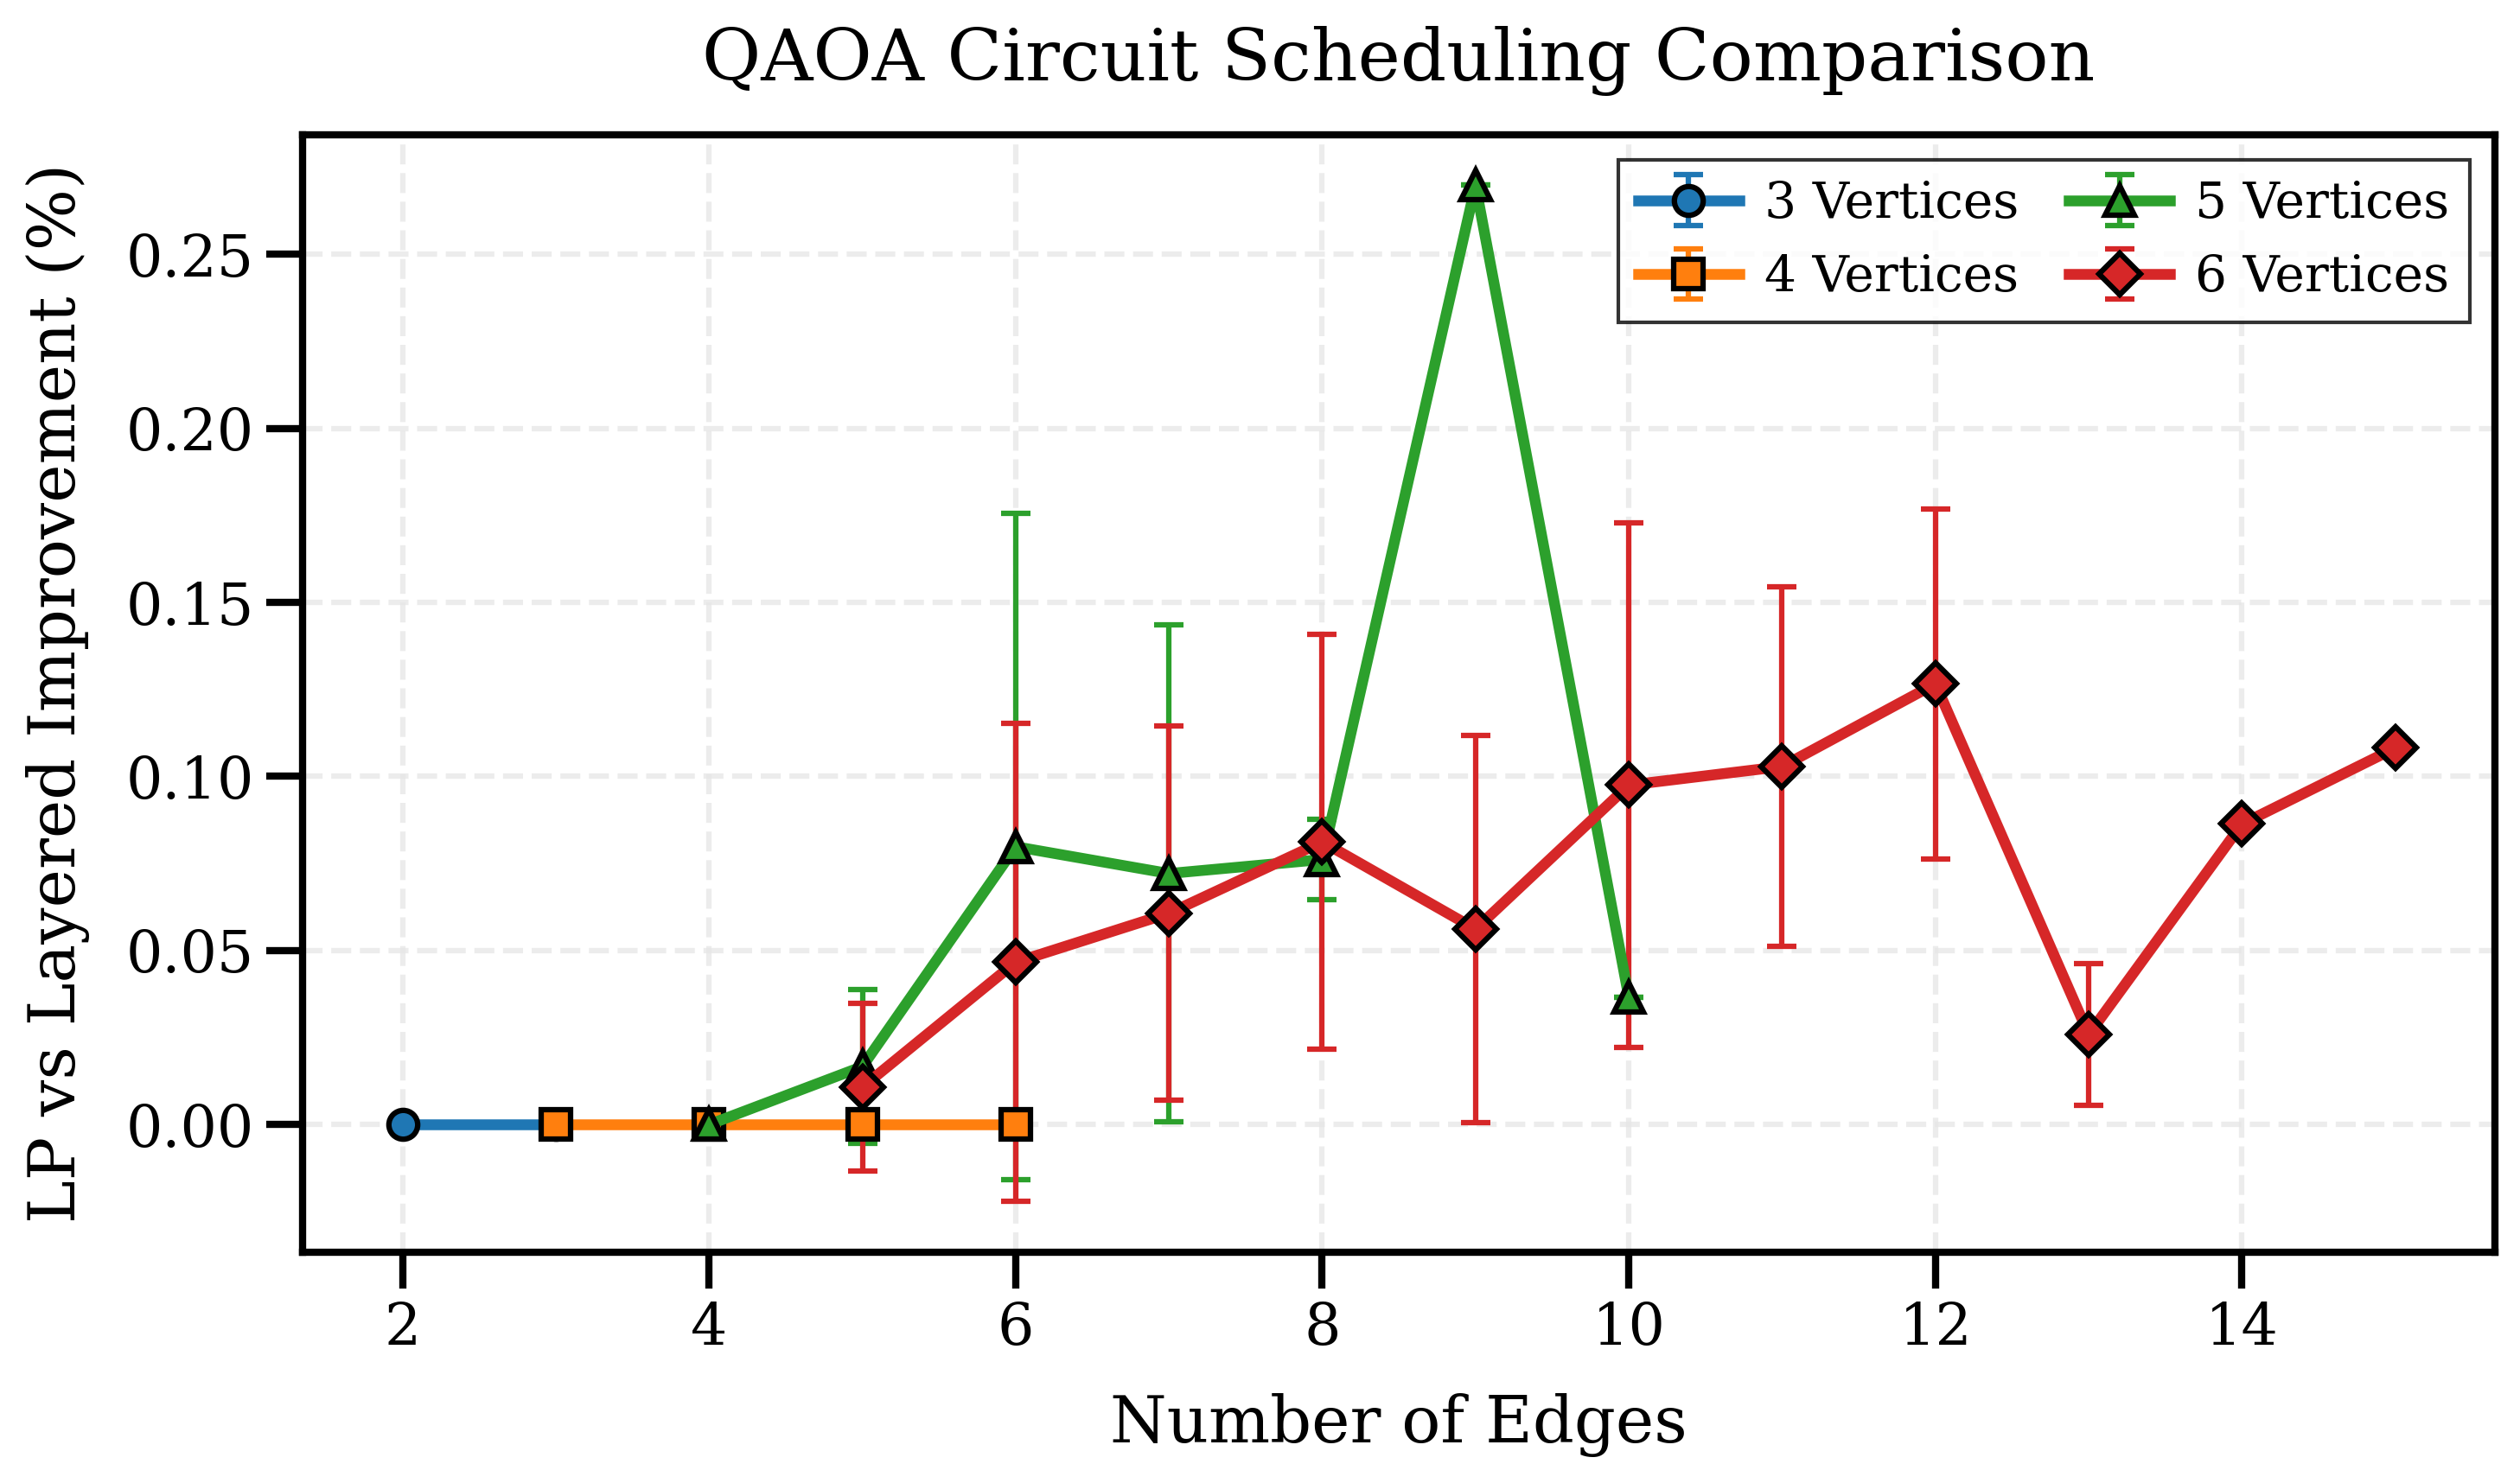

Analysis complete! Plot saved as 'improvement_analysis_v3-6.pdf'


In [3]:
def plot_multi_vertex_comparison(vertex_range=(3, 6)):
    """Create a publication-quality plot comparing different vertex counts."""
    # Set publication-quality style
    plt.rcParams.update(
        {
            "figure.figsize": (10, 6),  # More compact figure
            "figure.dpi": 300,
            "font.size": 16,  # Reduced base font size
            "font.family": "serif",
            "axes.labelsize": 18,  # Reduced label size
            "axes.titlesize": 20,  # Reduced title size
            "xtick.labelsize": 16,  # Reduced tick label size
            "ytick.labelsize": 16,
            "legend.fontsize": 14,  # Smaller legend font
            "figure.facecolor": "white",
            "axes.facecolor": "white",
            "axes.grid": True,
            "grid.color": "#E5E5E5",
            "grid.linewidth": 1.5,
            "lines.linewidth": 3,
            "axes.linewidth": 2,
            "xtick.major.width": 2,
            "ytick.major.width": 2,
            "xtick.major.size": 10,
            "ytick.major.size": 10,
        }
    )

    # Create figure
    fig, ax = plt.subplots()

    # Color map for different vertex counts
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
    markers = ["o", "s", "^", "D", "v", "<"]

    # Plot for each vertex count
    for i, n_vertices in enumerate(range(vertex_range[0], vertex_range[1] + 1)):
        # Create analyzer for this vertex count
        g6_path = f"./data/graphs/graph{n_vertices}c.g6"
        analyzer = QAOAAnalyzer(n_vertices, g6_path)

        # Get data
        edge_counts, means, stds = analyzer.process_all_graphs()

        # Plot with unique color and marker
        ax.errorbar(
            edge_counts,
            means,
            yerr=stds,
            fmt=f"{markers[i]}-",
            capsize=4,  # Smaller caps
            capthick=1.5,  # Thinner caps
            elinewidth=1.5,  # Thinner error bars
            markersize=8,  # Smaller markers
            color=colors[i],
            label=f"{n_vertices} Vertices",
            markeredgewidth=1.5,  # Thinner marker edges
            markeredgecolor="black",
        )

    # Customize plot
    ax.set_xlabel("Number of Edges", labelpad=10)
    ax.set_ylabel("LP vs Layered Improvement (%)", labelpad=10)
    ax.set_title("QAOA Circuit Scheduling Comparison", pad=15)

    # Force integer ticks for edge counts
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Add grid with specific style
    ax.grid(True, linestyle="--", alpha=0.7, linewidth=1.5)

    # Set axis padding
    ax.margins(x=0.05)

    # Customize legend - moved inside plot, more compact
    ax.legend(
        frameon=True,
        edgecolor="black",
        fancybox=False,
        loc="best",  # Automatically choose best location
        ncol=2,  # Use 2 columns for more compact legend
        columnspacing=1,  # Reduce space between columns
        handletextpad=0.5,
    )  # Reduce space between handle and text

    # Adjust layout to prevent text cutoff
    plt.tight_layout()

    # Save plot
    output_dir = Path("plots")
    output_dir.mkdir(exist_ok=True)
    plt.savefig(
        output_dir / f"improvement_analysis_v{vertex_range[0]}-{vertex_range[1]}.pdf",
        bbox_inches="tight",
        dpi=300,
        facecolor="white",
    )

    plt.show()

    print(
        f"Analysis complete! Plot saved as 'improvement_analysis_v{vertex_range[0]}-{vertex_range[1]}.pdf'"
    )


# Run the multi-vertex analysis
plot_multi_vertex_comparison(vertex_range=(3, 6))